# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/MyDrive/colab notebooks')
os.listdir()

Mounted at /content/drive


['train.csv',
 'test.csv',
 'jun_ml_extra_tech_boost-hw.ipynb',
 'finalized_model.sav',
 'Submission.csv',
 'jun_ml_kaggle_hw.ipynb']

In [ ]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    # Create new feature IsAlone from FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    # Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    # Remove all NULLS in the Fare column and create a new feature CategoricalFare
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [ ]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


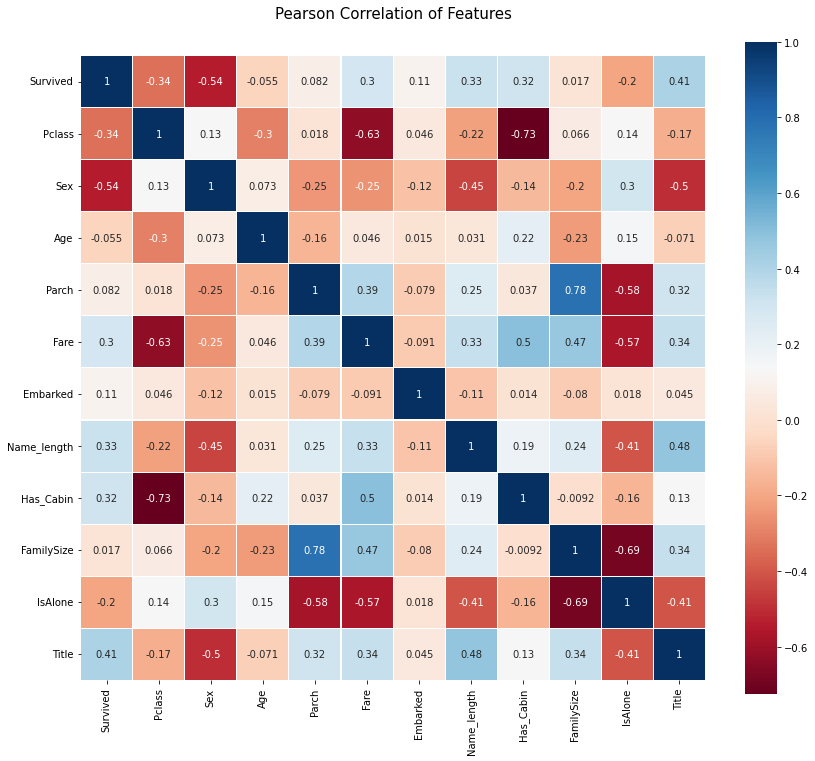

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

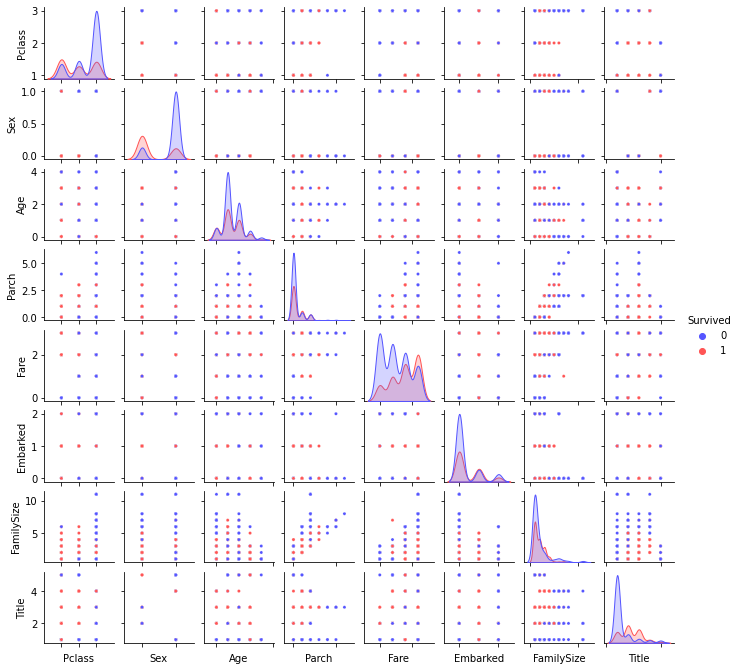

In [ ]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [ ]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                     cross_val_predict)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

class Stacking:

    from sklearn.exceptions import NotFittedError
    from xgboost.core import XGBoostError

    def __init__(self, models, meta_alg, random_state=None):
        self.models = models
        self.meta_alg = meta_alg
        self.random_state = random_state

        self.meta_best_score = 0
        self.meta_mtrx = None

    def grid_search(self, X, y, gs_params=None,
                    meta_gs_params=None, cv=5, meta_cv=5, scoring='None',
                    verbose=3):
        """
        Функция осуществляет перебор предоставленных
        параметров моделей gs_params и параметров метамодели meta_gs_params
        с целью найти наилучшие параметры при заданной метрике scoring.
        """

        if gs_params:
            for n, model in enumerate(self.models):
                if gs_params.get(model):
                    models_search = GridSearchCV(self.models[n],
                                                 gs_params.get(model),
                                                 cv=cv, scoring=scoring,
                                                 refit=True)
                    models_search.fit(X, y)
                    self.models[n] = models_search.best_estimator_
        
        if meta_gs_params:
            if not self.meta_mtrx:
                self.fit(X, y)

            meta_search = GridSearchCV(self.meta_alg, meta_gs_params,
                                       cv=meta_cv, verbose=verbose)
            meta_search.fit(self.meta_mtrx, y)
            
            self.meta_alg = meta_search.best_estimator_
            self.meta_best_score = meta_search.best_score_


    def fit(self, X, y, test_size=None, cv=5):

        # обучение с кросс-валидацией
        if test_size is None:
            self.meta_mtrx = np.empty((X.shape[0], len(self.models)))
            for n, model in enumerate(self.models):
                self.meta_mtrx[:, n] = cross_val_predict(model, X,
                                                        y, cv=cv,
                                                        method='predict')
                self.models[n].fit(X, y)
            self.meta_alg.fit(self.meta_mtrx, y)

        # обучение с валидационной выборкой
        elif 0 < test_size < 1:
            train, valid, train_true, valid_true = train_test_split(X, y,
                                                                    test_size=test_size,
                                                                    random_state=self.random_state)
            self.meta_mtrx = np.empty((valid.shape[0], len(self.models)))
            for n, model in enumerate(self.models):
                self.models[n] = model.fit(train, train_true)
                self.meta_mtrx[:, n] = model.predict(valid)
            self.meta_alg.fit(self.meta_mtrx, valid_true)

        else:
            raise ValueError("test_size must be between 0 and 1")

    def predict(self, X, test_size=None):

        meta_mtrx_test = np.empty((X.shape[0], len(self.models)))
        for n, model in enumerate(self.models):
            meta_mtrx_test[:, n] = model.predict(X)
        meta_predict = self.meta_alg.predict(meta_mtrx_test)
        return meta_predict

    def info(self, X=None, target_test=None):

        for i, model in enumerate(self.models):
            print(f'{i+1} model name: {type(model).__name__}')
            if X is not None and target_test is not None :
                try:
                    print(f'score: {accuracy_score(target_test, model.predict(X))}')
                except self.NotFittedError as e:
                    print(repr(e))
            print(f'model parameters: {model.get_params()}\n')

        print(f'metamodel name: {type(self.meta_alg).__name__}')
        print(f'score on train: {self.meta_best_score}')
        try:
            if X is not None and target_test is not None:
                print(f'score on test: {accuracy_score(target_test, self.predict(X))}')
        except self.XGBoostError as e:
                    print(repr(e))
        print(f'metamodel parameters: {self.meta_alg.get_params()}\n')


In [ ]:
# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

In [ ]:
X = train.drop(['Survived'], axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17, test_size=0.3)

params = (gbc_params, rfc_params, svc_params, lr_params)
models = [GradientBoostingClassifier(random_state=17),
          RandomForestClassifier(random_state=17),
          SVC(random_state=17),
          LogisticRegression(random_state=17)]
meta_model = XGBClassifier()
params = dict(zip(models, params))

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [ ]:
# grid search реализован в соответствующем методе класса Stacking

stacking = Stacking(models, meta_model, random_state=17)
stacking.grid_search(X_train, y_train, gs_params=params, cv=skf,
                     scoring='accuracy')

In [ ]:
stacking.info(X_test, y_test)

1 model name: GradientBoostingClassifier
score: 0.7649253731343284
model parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 17, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

2 model name: RandomForestClassifier
score: 0.8022388059701493
model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 17, 'verbose': 0, 'warm_start': False}

3 m

### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [ ]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [ ]:
stacking.grid_search(X_train, y_train, scoring='accuracy',
                     meta_gs_params=xgb_params, meta_cv=5)

Выходные данные были обрезаны до нескольких последних строк (5000).
[CV 1/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.1;, score=0.624 total time=   0.0s
[CV 2/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.1;, score=0.632 total time=   0.0s
[CV 3/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.1;, score=0.632 total time=   0.0s
[CV 4/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.1;, score=0.629 total time=   0.0s
[CV 5/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.1;, score=0.629 total time=   0.0s
[CV 1/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.30000000000000004;, score=0.832 total time=   0.0s
[CV 2/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.30000000000000004;, score=0.792 total time=   0.0s
[CV 3/5] END eta=0.8, min_child_weight=7, n_estimators=90, subsample=0.30000000000000004;, score=0.848 total time=   0.0s
[CV 4/5] END eta=0.8, min_child_weig

In [ ]:
stacking.fit(X_train, y_train)
stacking.info(X_test, y_test)


1 model name: GradientBoostingClassifier
score: 0.7649253731343284
model parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 17, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

2 model name: RandomForestClassifier
score: 0.8022388059701493
model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 17, 'verbose': 0, 'warm_start': False}

3 m

In [ ]:
# добавим еще один параметр в мета-алгоритм
stacking.meta_alg.scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

stacking.fit(X_train, y_train)
stacking.info(X_test, y_test)

1 model name: GradientBoostingClassifier
score: 0.7649253731343284
model parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 17, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

2 model name: RandomForestClassifier
score: 0.8022388059701493
model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 17, 'verbose': 0, 'warm_start': False}

3 m

### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [ ]:
stacking.fit(X, y)
meta_predictions = stacking.predict(test)

In [ ]:
meta_predictions = stacking.predict(test)

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [ ]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)
    display(predicted_df)

In [ ]:
write_to_submission_file(meta_predictions, PassengerId)

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### 6.
Каков результат score, полученного на соревновании?

Ваш ответ:


*   0.76076 при стандартном значении scale_pos_weight мета-алгоритма
*   0.75837 при скорректированном scale_pos_weight







